In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2

In [2]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

figure_size = dict(
    ultra=45,
    large=35,
    middle=20,
    small=10,
    very_small=5
)

def set_plt(figsize=(10, 10)):
    params = {'axes.titlesize': figure_size['ultra'],
              'legend.fontsize': figure_size['middle'],
              'figure.figsize': figsize,
              'axes.labelsize': figure_size['ultra'],
              'xtick.labelsize': figure_size['ultra'],
              'ytick.labelsize': figure_size['ultra'],
              'figure.titlesize': figure_size['ultra'],
              'lines.linewidth': figure_size['very_small']}
    plt.rcParams.update(params)

    font = {'family': 'sans-serif', 'sans-serif': 'Arial'}
    plt.rc('font', **font)

def set_Border(axes):
    axes.spines['top'].set_color('none')
    axes.spines['right'].set_color('none')
    axes.spines['bottom'].set_color('black')
    axes.spines['left'].set_color('black')
    axes.spines['bottom'].set_linewidth(figure_size['very_small'])
    axes.spines['left'].set_linewidth(figure_size['very_small'])
    axes.tick_params(axis='both', width=figure_size['very_small'], length=figure_size['small'])

In [3]:
colors = {
    'hr': (255/255, 122/255, 23/255),
    'mine': (0, 191/255, 82/255)
}
figure_file_path = 'figure_file/mustache'

attentions = 50
center = attentions - 1

def read_chiqseq_file(path):
    _peaks = dict()
    with open(path)as f:
        for line in f:
            datas = line.strip().split()
            left, right = int(int(datas[1])/1000), int(int(datas[2])/1000)
            peaks = list(range(left, right+1))
            if datas[0] not in _peaks.keys():
                _peaks[datas[0]] = set()
            for i in peaks:
                _peaks[datas[0]].add(i)
    return _peaks

def get_hit_indicators(significants, peaks):
    distance = np.zeros(attentions*2-1)
    
    for sig in significants:
        x, y = int(sig[0]), int(sig[1])
        for i in range(attentions):
            if (x+i) in peaks or (y+i) in peaks:
                distance[center-i] += 1
            if i != 0 and((x-i) in peaks or (y-i) in peaks):
                distance[center+i] += 1
            if (x+i) in peaks or (x-i) in peaks or (y+i) in peaks or (y-i) in peaks:
                break
    return distance

def show(x, mine_result, hr_result, title):
    set_plt()
    
    fig, axes = plt.subplots(nrows=1, ncols=1, sharey=True)
    axes.grid(False)
    axes.plot(x, mine_result, color=colors['mine'], label='MINE')
    axes.plot(x, hr_result, color=colors['hr'], label='High resolution')

    set_Border(axes)
    axes.set_xticks([-40, 0, 40])
    axes.set_xticklabels(['-40K', 'Loop anchor', '40K'])
    
    plt.annotate(str(int(mine_result[center])), xy=(0,mine_result[center]), xytext=(0,mine_result[center]), fontsize=figure_size['middle'])
    plt.annotate(str(int(hr_result[center])), xy=(0,hr_result[center]), xytext=(0,hr_result[center]), fontsize=figure_size['middle'])

    plt.ylabel('Number of Peaks')
    plt.legend(
        facecolor='white', loc='upper right', framealpha=0, handletextpad=1, borderpad=0, borderaxespad=0
    ).get_frame().set_linewidth(0.0)
    plt.savefig('{}/{}.pdf'.format(figure_file_path, title), format='pdf', bbox_inches='tight')
    plt.show()

def figure(chip_seq_path, all_enhanced_sig, all_hr_sig, title):
    all_enhanced_result = np.zeros(attentions*2-1)
    all_hr_result = np.zeros(attentions*2-1)

    for chr in range(1, 23):
        _peaks = read_chiqseq_file(chip_seq_path)
        enhanced_result = get_hit_indicators(all_enhanced_sig[chr], _peaks['chr{}'.format(chr)])
        hr_result = get_hit_indicators(all_hr_sig[chr], _peaks['chr{}'.format(chr)])

        all_enhanced_result += enhanced_result
        all_hr_result += hr_result

    show(list(range(-attentions+1, attentions)), all_enhanced_result, all_hr_result, title)

def show_venn(enhanced_sig_set, hr_sig_set, file_name):
    venn2(
        subsets = [hr_sig_set, enhanced_sig_set],
        set_labels = ('High resolution', 'MINE'),
        set_colors=(colors['hr'], colors['mine'])
    )
    plt.savefig('{}/{}.pdf'.format(figure_file_path, file_name))
    plt.show()

In [4]:
verificate_temp_path = '../verificate/temp'
auxiliary_files_path = '/data1/lmh_data/MINE/source/GM12878'

_enhanced_sigs = np.load(
    '{}/GM12878_ATAC_H3K27ac_H3K4me3_2_100_mustache__enhanced_sigs.npy'.format(verificate_temp_path),
    allow_pickle=True
).item()
_hr_sigs = np.load(
    '{}/GM12878_ATAC_H3K27ac_H3K4me3_2_100_mustache__hr_sigs.npy'.format(verificate_temp_path),
    allow_pickle=True
).item()
all_enhanced_sig = np.load(
    '{}/GM12878_ATAC_H3K27ac_H3K4me3_2_100_mustache_all_enhanced_sig.npy'.format(verificate_temp_path),
    allow_pickle=True
).item()
all_hr_sig = np.load(
    '{}/GM12878_ATAC_H3K27ac_H3K4me3_2_100_mustache_all_hr_sig.npy'.format(verificate_temp_path),
    allow_pickle=True
).item()

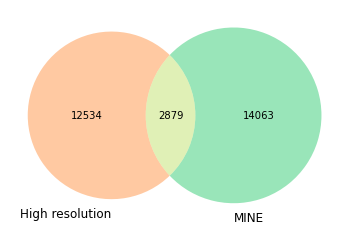

In [5]:
show_venn(_enhanced_sigs, _hr_sigs, file_name='venn')

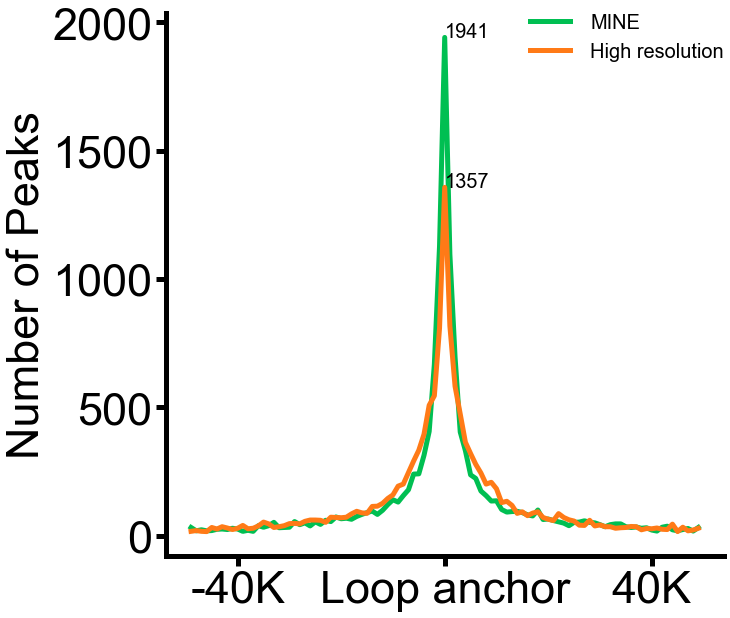

In [6]:
chip_seq_path = os.path.join(auxiliary_files_path, 'CTCF_peaks.bed')
figure(chip_seq_path, all_enhanced_sig, all_hr_sig, title='CTCF overlap')

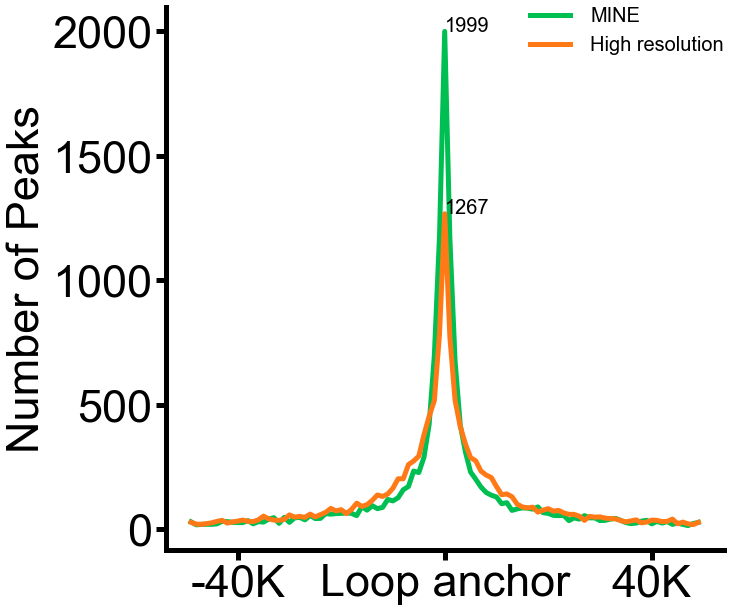

In [7]:
chip_seq_path = os.path.join(auxiliary_files_path, 'RAD21_peaks.bed')
figure(chip_seq_path, all_enhanced_sig, all_hr_sig, title='RAD21 overlap')

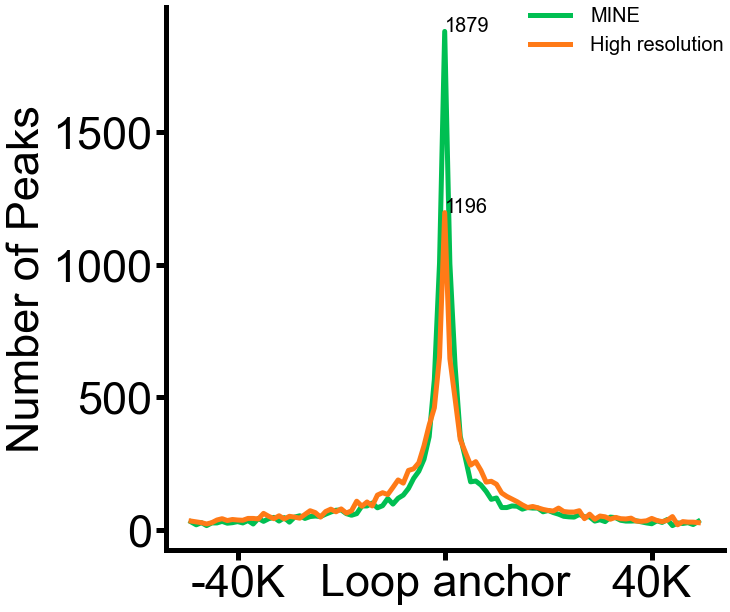

In [8]:
chip_seq_path = os.path.join(auxiliary_files_path, 'SMC3_peaks.bed')
figure(chip_seq_path, all_enhanced_sig, all_hr_sig, title='SMC3 overlap')

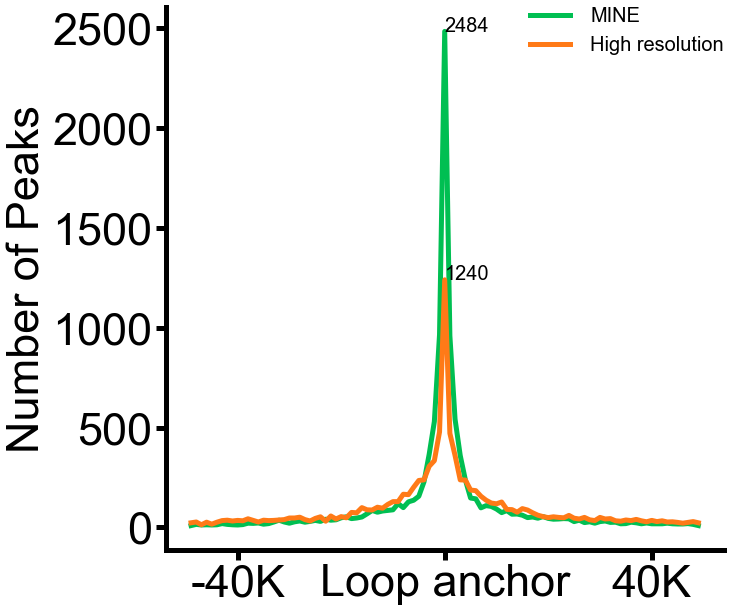

In [9]:
chip_seq_path = os.path.join(auxiliary_files_path, 'POLR2A_peaks.bed')
figure(chip_seq_path, all_enhanced_sig, all_hr_sig, title='POLR2A overlap')

In [10]:
tss_file_path = os.path.join(auxiliary_files_path, 'Homo_sapiens.GRCh38.104.chr.gff3')

def get_tss_gene_info(gene_biotype='protein_coding'):
    gene_location = dict()
    gene_info = dict()
    with open(tss_file_path, "r") as f:
        datas = f.readlines()
        for data in datas[9:]:
            data = data.split('\t')
            if len(data) < 9:
                continue
            if data[2] != 'gene' or data[8].find(gene_biotype) == -1:
                continue
            if data[6] == '+':
                _location = data[3]
            elif data[6] == '-':
                _location = data[4]
            else:
                print('error')
            if not data[0].isdigit():
                continue
            chromosome = int(data[0])
            if chromosome not in gene_location:
                gene_location[chromosome] = set()
            gene_location[chromosome].add(int(int(_location)/1000))
            
            _tmp = data[-1].split('Name=')
            if len(_tmp) < 2:
                continue
            gene_names = _tmp[1].split(';')[0]
            gene_ids = data[-1].split('ID=')[1].split(',')[0].split(';')[0]
            
            if chromosome not in gene_info:
                gene_info[chromosome] = set()
            gene_info[chromosome].add((int(int(_location)/1000), gene_names, gene_ids, data[-1].replace('\n', '')))
    return gene_location, gene_info

def figure_tss(locations, all_enhanced_sig, all_hr_sig, title):
    all_enhanced_result = np.zeros(attentions*2-1)
    all_hr_result = np.zeros(attentions*2-1)

    for chr in range(1, 23):
        if chr not in locations:
            continue
        enhanced_result = get_hit_indicators(all_enhanced_sig[chr], locations[chr])
        hr_result = get_hit_indicators(all_hr_sig[chr], locations[chr])

        all_enhanced_result += enhanced_result
        all_hr_result += hr_result

    show(list(range(-attentions+1, attentions)), all_enhanced_result, all_hr_result, title)

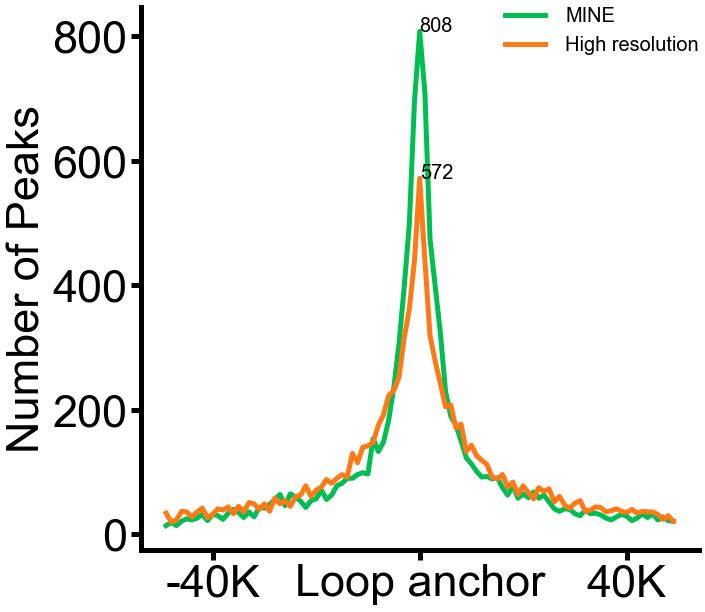

In [11]:
gene_location = get_tss_gene_info('protein_coding')[0]
figure_tss(gene_location, all_enhanced_sig, all_hr_sig, title='TSS overlap')